# Introduction

In this notebook we try to use the information provided by 'burea' and 'burea_balance data'. Here are the definition of each files:

* bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
* bureau_balance: monthly information about the previous loans. Each month has its own row.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


Read the app_train data set

In [250]:
app_train = pd.read_csv('home-credit-data/application_train.csv')

In [3]:
app_train.shape

(307511, 122)

In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


EDA for the 'app_train' data set was done in notebook 1. For more information on EDA and feature engineering please refer to the notebook 1. 

In [5]:
 app_train = app_train.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
        'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
        'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], axis =1)

In [6]:
# Flag to represent when Total income is greater than Credit
app_train['INCOME_GT_CREDIT_FLAG'] = app_train['AMT_INCOME_TOTAL'] > app_train['AMT_CREDIT']

# Column to represent Credit Income Percent
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']

# Column to represent Annuity Income percent
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']

# Column to represent Credit Term
app_train['CREDIT_TERM'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY'] 

# Column to represent Days Employed percent in his life
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

# Shape of Application data
print('The shape of application data:',app_train.shape)

The shape of application data: (307511, 102)


## 1. Merge with 'bureau' data

Read 'bureau' data set

In [7]:
bureau = pd.read_csv('home-credit-data/bureau.csv')

In [8]:
bureau.head(20)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


In [9]:
bureau.shape

(1716428, 17)

Lets have a look to the columns with null value

In [10]:
bureau.isnull().any().sum()

7

In [11]:
count = bureau.isnull().sum().sort_values(ascending=False)
percentage = (bureau.isnull().sum()*100/len(bureau)).sort_values(ascending=False)

table_miss_val = pd.concat([count,percentage], axis=1, keys=['Count', 'Percentage (%)'])

In [12]:
table_miss_val

,Count,Percentage (%)
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_TYPE,0,0.000000
AMT_CREDIT_SUM_OVERDUE,0,0.000000
CNT_CREDIT_PROLONG,0,0.000000


We group by 'bureau' data set based on the 'SK_ID_CURR' and then add the column 'previous_loan_counts' to the 'aap_train' dataset

In [13]:
# Groupby the client id and count the number of previous loans
previous_loan_counts = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].agg(['count']).reset_index()



In [14]:
previous_loan_counts

,SK_ID_CURR,count
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [15]:
# rename the column
previous_loan_counts = previous_loan_counts.rename(columns = {'count': 'previous_loan_counts'})



In [16]:
previous_loan_counts

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [17]:
# Merge with the parent dataframe
app_train = app_train.merge(previous_loan_counts[['SK_ID_CURR', 'previous_loan_counts']], 
                on = 'SK_ID_CURR', how = 'left')

In [18]:
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)

In [19]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INCOME_GT_CREDIT_FLAG,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,False,2.007889,0.121978,16.461104,0.067329,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,False,4.790750,0.132217,36.234085,0.070862,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,False,2.000000,0.100000,20.000000,0.011814,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,False,2.316167,0.219900,10.532818,0.159905,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,False,4.222222,0.179963,23.461618,0.152418,1.0


By scrolling to the left, the newly added column can be seen.

We plot the 'previous_loan_counts' for the clients who repay and default. 

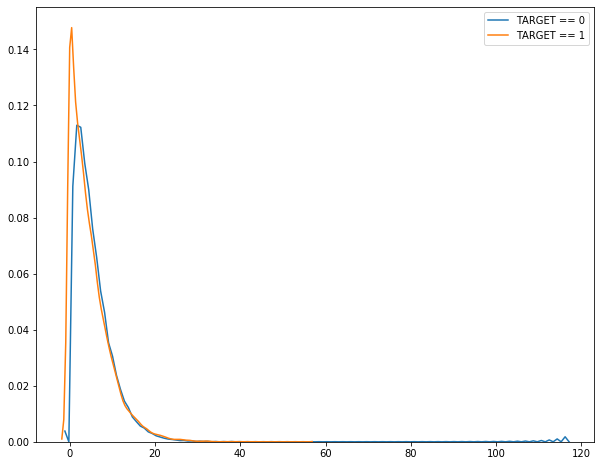

In [20]:
plt.figure(figsize=(10,8))
sns.kdeplot(app_train[app_train["TARGET"]==0]["previous_loan_counts"], label = 'TARGET == 0')
sns.kdeplot(app_train[app_train["TARGET"]==1]["previous_loan_counts"], label = 'TARGET == 1')


### 1.1 Aggregating numerical features

Before we add any column, we will replace NaN values with zero. In the next step we will drop the 'SK_ID_BUREAU'

In [21]:
bureau_c = bureau.copy()

In [22]:
for i in bureau_c.columns:
    if bureau_c[i].isnull().any()==True:
        bureau_c[i]=bureau_c[i].fillna((0))

In [23]:
bureau_c = bureau_c.drop(['SK_ID_BUREAU'], axis =1)

grouping numeric features:

In [24]:
num_bureau = bureau_c.groupby('SK_ID_CURR').agg(['mean', 'max', 'min', 'sum']).reset_index()

In [25]:
num_bureau.head()

SK_ID_CURR  DAYS_CREDIT                  CREDIT_DAY_OVERDUE              \
                     mean  max   min   sum               mean max min sum   
0     100001  -735.000000  -49 -1572 -5145                0.0   0   0   0   
1     100002  -874.000000 -103 -1437 -6992                0.0   0   0   0   
2     100003 -1400.750000 -606 -2586 -5603                0.0   0   0   0   
3     100004  -867.000000 -408 -1326 -1734                0.0   0   0   0   
4     100005  -190.666667  -62  -373  -572                0.0   0   0   0   

  DAYS_CREDIT_ENDDATE  ... AMT_CREDIT_SUM_OVERDUE      DAYS_CREDIT_UPDATE  \
                 mean  ...                    min  sum               mean   
0           82.428571  ...                    0.0  0.0         -93.142857   
1         -261.750000  ...                    0.0  0.0        -499.875000   
2         -544.500000  ...                    0.0  0.0        -816.000000   
3         -488.500000  ...                    0.0  0.0        -532.000000   
4          439.333333  ...                    0.0  0.0         -54.333333   

                    AMT_ANNUITY                         
   max   min   sum         mean      max  min      sum  
0   -6  -155  -652  3545.357143  10822.5  0.0  24817.5  
1   -7 -1185 -3999     0.000000      0.0  0.0      0.0  
2  -43 -2131 -3264     0.000000      0.0  0.0      0.0  
3 -382  -682 -1064     0.000000      0.0  0.0      0.0  
4  -11  -121  -163  1420.500000   4261.5  0.0   4261.5  

[5 rows x 49 columns]

In [26]:
num_bureau.columns

MultiIndex([(            'SK_ID_CURR',     ''),
            (           'DAYS_CREDIT', 'mean'),
            (           'DAYS_CREDIT',  'max'),
            (           'DAYS_CREDIT',  'min'),
            (           'DAYS_CREDIT',  'sum'),
            (    'CREDIT_DAY_OVERDUE', 'mean'),
            (    'CREDIT_DAY_OVERDUE',  'max'),
            (    'CREDIT_DAY_OVERDUE',  'min'),
            (    'CREDIT_DAY_OVERDUE',  'sum'),
            (   'DAYS_CREDIT_ENDDATE', 'mean'),
            (   'DAYS_CREDIT_ENDDATE',  'max'),
            (   'DAYS_CREDIT_ENDDATE',  'min'),
            (   'DAYS_CREDIT_ENDDATE',  'sum'),
            (     'DAYS_ENDDATE_FACT', 'mean'),
            (     'DAYS_ENDDATE_FACT',  'max'),
            (     'DAYS_ENDDATE_FACT',  'min'),
            (     'DAYS_ENDDATE_FACT',  'sum'),
            ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
            ('AMT_CREDIT_MAX_OVERDUE',  'max'),
            ('AMT_CREDIT_MAX_OVERDUE',  'min'),
            ('AMT_CREDIT_MAX_OVERDUE',  

In [27]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in num_bureau.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':        
        # Iterate through the stat names
        for stat in num_bureau.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [28]:
columns

['SK_ID_CURR',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_sum',
 'bureau_CREDIT_DAY_OVERDUE_mean',
 'bureau_CREDIT_DAY_OVERDUE_max',
 'bureau_CREDIT_DAY_OVERDUE_min',
 'bureau_CREDIT_DAY_OVERDUE_sum',
 'bureau_DAYS_CREDIT_ENDDATE_mean',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_ENDDATE_min',
 'bureau_DAYS_CREDIT_ENDDATE_sum',
 'bureau_DAYS_ENDDATE_FACT_mean',
 'bureau_DAYS_ENDDATE_FACT_max',
 'bureau_DAYS_ENDDATE_FACT_min',
 'bureau_DAYS_ENDDATE_FACT_sum',
 'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
 'bureau_AMT_CREDIT_MAX_OVERDUE_max',
 'bureau_AMT_CREDIT_MAX_OVERDUE_min',
 'bureau_AMT_CREDIT_MAX_OVERDUE_sum',
 'bureau_CNT_CREDIT_PROLONG_mean',
 'bureau_CNT_CREDIT_PROLONG_max',
 'bureau_CNT_CREDIT_PROLONG_min',
 'bureau_CNT_CREDIT_PROLONG_sum',
 'bureau_AMT_CREDIT_SUM_mean',
 'bureau_AMT_CREDIT_SUM_max',
 'bureau_AMT_CREDIT_SUM_min',
 'bureau_AMT_CREDIT_SUM_sum',
 'bureau_AMT_CREDIT_SUM_DEBT_mean',
 'bureau_AMT_CREDI

In [29]:
num_bureau.columns=columns

In [30]:
num_bureau.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,-735.000000,-49,-1572,-5145,0.0,0,0,0,82.428571,...,0.0,0.0,-93.142857,-6,-155,-652,3545.357143,10822.5,0.0,24817.5
1,100002,-874.000000,-103,-1437,-6992,0.0,0,0,0,-261.750000,...,0.0,0.0,-499.875000,-7,-1185,-3999,0.000000,0.0,0.0,0.0
2,100003,-1400.750000,-606,-2586,-5603,0.0,0,0,0,-544.500000,...,0.0,0.0,-816.000000,-43,-2131,-3264,0.000000,0.0,0.0,0.0
3,100004,-867.000000,-408,-1326,-1734,0.0,0,0,0,-488.500000,...,0.0,0.0,-532.000000,-382,-682,-1064,0.000000,0.0,0.0,0.0
4,100005,-190.666667,-62,-373,-572,0.0,0,0,0,439.333333,...,0.0,0.0,-54.333333,-11,-121,-163,1420.500000,4261.5,0.0,4261.5


In [31]:
num_bureau.shape

(305811, 49)

### 1.2 Aggregating categorical features 

In [32]:
cat_bureau = pd.get_dummies(bureau_c.select_dtypes('object'))

In [33]:
cat_bureau.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cat_bureau['SK_ID_CURR'] = bureau_c['SK_ID_CURR']

In [35]:
cat_bureau.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [36]:
cat_bureau = cat_bureau.groupby('SK_ID_CURR').agg(['mean']).reset_index()

In [37]:
cat_bureau.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,100001,0.428571,0.0,0.571429,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in cat_bureau.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':        
        # Iterate through the stat names
        for stat in cat_bureau.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [39]:
cat_bureau.columns=columns

In [40]:
cat_bureau.head()

,SK_ID_CURR,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Sold_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 3_mean,bureau_CREDIT_CURRENCY_currency 4_mean,bureau_CREDIT_TYPE_Another type of loan_mean,...,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for the purchase of equipment_mean,bureau_CREDIT_TYPE_Loan for working capital replenishment_mean,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_mean
0,100001,0.428571,0.0,0.571429,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we merge these two new dataframe with the 'app_train' data 

In [41]:
app_train_bureau = app_train.merge(num_bureau, on='SK_ID_CURR', how='left')

In [42]:
app_train_bureau.shape

(307511, 151)

In [43]:
app_train_bureau = app_train.merge(cat_bureau, on='SK_ID_CURR', how='left')

In [44]:
app_train_bureau.shape

(307511, 126)

In [45]:
app_train_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for the purchase of equipment_mean,bureau_CREDIT_TYPE_Loan for working capital replenishment_mean,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Merge with 'burea_balance' data

Read the file

In [46]:
bureau_balance = pd.read_csv('home-credit-data/bureau_balance.csv')

In [47]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [48]:
bureau_balance_c = bureau_balance.copy()

### 2.1 Aggregating categorical features 

Counts each 'STATUS' for different loan

In [49]:
cat_bureau_balance = pd.get_dummies(bureau_balance_c.select_dtypes('object'))

In [50]:
cat_bureau_balance

,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
27299920,0,0,0,0,0,0,0,1
27299921,0,0,0,0,0,0,0,1
27299922,0,0,0,0,0,0,0,1
27299923,0,0,0,0,0,0,0,1


In [51]:
cat_bureau_balance['SK_ID_BUREAU'] = bureau_balance_c['SK_ID_BUREAU']

In [52]:
cat_bureau_balance.head()

,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,SK_ID_BUREAU
0,0,0,0,0,0,0,1,0,5715448
1,0,0,0,0,0,0,1,0,5715448
2,0,0,0,0,0,0,1,0,5715448
3,0,0,0,0,0,0,1,0,5715448
4,0,0,0,0,0,0,1,0,5715448


In [53]:
cat_bureau_balance = cat_bureau_balance.groupby('SK_ID_BUREAU').agg(['mean']).reset_index()

In [54]:
# List of column names
columns = ['SK_ID_BUREAU']

# Iterate through the variables names
for var in cat_bureau_balance.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_BUREAU':        
        # Iterate through the stat names
        for stat in cat_bureau_balance.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_balance_%s_%s' % (var, stat))

In [55]:
cat_bureau_balance.columns=columns

In [56]:
cat_bureau_balance.head()

,SK_ID_BUREAU,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_mean
0,5001709,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402
1,5001710,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446
2,5001711,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000
3,5001712,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000
4,5001713,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000


In [57]:
cat_bureau_balance = cat_bureau_balance.set_index(['SK_ID_BUREAU'])

### 2.2 Aggregating numerical features 

In [58]:
num_bureau_balance = bureau_balance_c.groupby('SK_ID_BUREAU').agg(['mean', 'max', 'min', 'sum']).reset_index()

In [59]:
num_bureau_balance

SK_ID_BUREAU MONTHS_BALANCE              
                              mean max min   sum
0           5001709          -48.0   0 -96 -4656
1           5001710          -41.0   0 -82 -3403
2           5001711           -1.5   0  -3    -6
3           5001712           -9.0   0 -18  -171
4           5001713          -10.5   0 -21  -231
...             ...            ...  ..  ..   ...
817390      6842884          -23.5   0 -47 -1128
817391      6842885          -11.5   0 -23  -276
817392      6842886          -16.0   0 -32  -528
817393      6842887          -18.0   0 -36  -666
817394      6842888          -30.5   0 -61 -1891

[817395 rows x 5 columns]

In [60]:
# List of column names
columns = ['SK_ID_BUREAU']

# Iterate through the variables names
for var in num_bureau_balance.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_BUREAU':        
        # Iterate through the stat names
        for stat in num_bureau_balance.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_balance_%s_%s' % (var, stat))

In [61]:
num_bureau_balance.columns=columns

In [62]:
num_bureau_balance.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,-48.0,0,-96,-4656
1,5001710,-41.0,0,-82,-3403
2,5001711,-1.5,0,-3,-6
3,5001712,-9.0,0,-18,-171
4,5001713,-10.5,0,-21,-231


In [63]:
bureau_by_loan = num_bureau_balance.merge(cat_bureau_balance, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

In [64]:
bureau_by_loan

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_mean
0,5001709,-48.0,0,-96,-4656,0.000000,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402
1,5001710,-41.0,0,-82,-3403,0.060241,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446
2,5001711,-1.5,0,-3,-6,0.750000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000
3,5001712,-9.0,0,-18,-171,0.526316,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000
4,5001713,-10.5,0,-21,-231,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,-23.5,0,-47,-1128,0.187500,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833
817391,6842885,-11.5,0,-23,-276,0.500000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000
817392,6842886,-16.0,0,-32,-528,0.242424,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000
817393,6842887,-18.0,0,-36,-666,0.162162,0.000000,0.0,0.0,0.0,0.0,0.837838,0.000000


In [65]:
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

In [66]:
bureau_by_loan


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_mean,SK_ID_CURR
0,5001709,-48.0,0,-96,-4656,0.000000,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402,NaN
1,5001710,-41.0,0,-82,-3403,0.060241,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446,162368.0
2,5001711,-1.5,0,-3,-6,0.750000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000,162368.0
3,5001712,-9.0,0,-18,-171,0.526316,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000,162368.0
4,5001713,-10.5,0,-21,-231,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,150635.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,-23.5,0,-47,-1128,0.187500,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833,387020.0
817391,6842885,-11.5,0,-23,-276,0.500000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,387020.0
817392,6842886,-16.0,0,-32,-528,0.242424,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000,387020.0
817393,6842887,-18.0,0,-36,-666,0.162162,0.000000,0.0,0.0,0.0,0.0,0.837838,0.000000,387020.0


In [67]:
bureau_by_loan.isna().any().sum()

1

In [68]:
bureau_by_loan = bureau_by_loan.drop(['SK_ID_BUREAU'], axis =1)

In [69]:
bureau_balance_by_client = bureau_by_loan.groupby('SK_ID_CURR').agg(['mean', 'max', 'min', 'sum']).reset_index()

In [70]:
bureau_balance_by_client

SK_ID_CURR bureau_balance_MONTHS_BALANCE_mean                     \
                                                mean   max   min    sum   
0        100001.0                         -11.785714  -0.5 -25.5  -82.5   
1        100002.0                         -21.875000  -1.5 -39.5 -175.0   
2        100005.0                          -3.000000  -1.0  -6.0   -9.0   
3        100010.0                         -46.000000 -19.5 -72.5  -92.0   
4        100013.0                         -28.250000 -19.5 -34.0 -113.0   
...           ...                                ...   ...   ...    ...   
134537   456247.0                         -19.863636  -4.5 -53.0 -218.5   
134538   456250.0                         -14.000000 -12.5 -16.0  -42.0   
134539   456253.0                         -14.125000 -11.5 -15.0  -56.5   
134540   456254.0                         -18.000000 -18.0 -18.0  -18.0   
134541   456255.0                         -22.272727  -5.5 -60.0 -245.0   

       bureau_balance_MONTHS_BALANCE_max               \
                                    mean max min  sum   
0                               0.000000   0   0    0   
1                             -15.500000   0 -32 -124   
2                               0.000000   0   0    0   
3                             -28.500000  -2 -55  -57   
4                               0.000000   0   0    0   
...                                  ...  ..  ..  ...   
134537                         -5.818182   0 -40  -64   
134538                          0.000000   0   0    0   
134539                          0.000000   0   0    0   
134540                          0.000000   0   0    0   
134541                         -9.454545   0 -44 -104   

       bureau_balance_MONTHS_BALANCE_min  ... bureau_balance_STATUS_5_mean  \
                                    mean  ...                          min   
0                             -23.571429  ...                          0.0   
1                             -28.250000  ...                          0.0   
2                              -6.000000  ...                          0.0   
3                             -63.500000  ...                          0.0   
4                             -56.500000  ...                          0.0   
...                                  ...  ...                          ...   
134537                        -33.909091  ...                          0.0   
134538                        -28.000000  ...                          0.0   
134539                        -28.250000  ...                          0.0   
134540                        -36.000000  ...                          0.0   
134541                        -35.090909  ...                          0.0   

            bureau_balance_STATUS_C_mean                                \
        sum                         mean       max       min       sum   
0       0.0                     0.441240  0.966667  0.000000  3.088683   
1       0.0                     0.175426  0.812500  0.000000  1.403409   
2       0.0                     0.128205  0.384615  0.000000  0.384615   
3       0.0                     0.722222  0.722222  0.722222  1.444444   
4       0.0                     0.397036  0.666667  0.000000  1.588142   
...     ...                          ...       ...       ...       ...   
134537  0.0                     0.505634  0.965517  0.000000  5.561970   
134538  0.0                     0.252525  0.757576  0.000000  0.757576   
134539  0.0                     0.459677  0.612903  0.000000  1.838710   
134540  0.0                     0.783784  0.783784  0.783784  0.783784   
134541  0.0                     0.645601  0.942857  0.230769  7.101613   

       bureau_balance_STATUS_X_mean                                
                               mean       max       min       sum  
0                          0.214590  0.500000  0.000000  1.502129  
1                          0.161932  0.500000  0.000000  1.295455  
2                          0.136752  0.

In [71]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_balance_by_client.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':        
        # Iterate through the stat names
        for stat in bureau_balance_by_client.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('by_client_%s_%s' % (var, stat))

In [72]:
bureau_balance_by_client.columns=columns

In [73]:
bureau_balance_by_client

,SK_ID_CURR,by_client_bureau_balance_MONTHS_BALANCE_mean_mean,by_client_bureau_balance_MONTHS_BALANCE_mean_max,by_client_bureau_balance_MONTHS_BALANCE_mean_min,by_client_bureau_balance_MONTHS_BALANCE_mean_sum,by_client_bureau_balance_MONTHS_BALANCE_max_mean,by_client_bureau_balance_MONTHS_BALANCE_max_max,by_client_bureau_balance_MONTHS_BALANCE_max_min,by_client_bureau_balance_MONTHS_BALANCE_max_sum,by_client_bureau_balance_MONTHS_BALANCE_min_mean,...,by_client_bureau_balance_STATUS_5_mean_min,by_client_bureau_balance_STATUS_5_mean_sum,by_client_bureau_balance_STATUS_C_mean_mean,by_client_bureau_balance_STATUS_C_mean_max,by_client_bureau_balance_STATUS_C_mean_min,by_client_bureau_balance_STATUS_C_mean_sum,by_client_bureau_balance_STATUS_X_mean_mean,by_client_bureau_balance_STATUS_X_mean_max,by_client_bureau_balance_STATUS_X_mean_min,by_client_bureau_balance_STATUS_X_mean_sum
0,100001.0,-11.785714,-0.5,-25.5,-82.5,0.000000,0,0,0,-23.571429,...,0.0,0.0,0.441240,0.966667,0.000000,3.088683,0.214590,0.500000,0.000000,1.502129
1,100002.0,-21.875000,-1.5,-39.5,-175.0,-15.500000,0,-32,-124,-28.250000,...,0.0,0.0,0.175426,0.812500,0.000000,1.403409,0.161932,0.500000,0.000000,1.295455
2,100005.0,-3.000000,-1.0,-6.0,-9.0,0.000000,0,0,0,-6.000000,...,0.0,0.0,0.128205,0.384615,0.000000,0.384615,0.136752,0.333333,0.000000,0.410256
3,100010.0,-46.000000,-19.5,-72.5,-92.0,-28.500000,-2,-55,-57,-63.500000,...,0.0,0.0,0.722222,0.722222,0.722222,1.444444,0.000000,0.000000,0.000000,0.000000
4,100013.0,-28.250000,-19.5,-34.0,-113.0,0.000000,0,0,0,-56.500000,...,0.0,0.0,0.397036,0.666667,0.000000,1.588142,0.254545,1.000000,0.000000,1.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134537,456247.0,-19.863636,-4.5,-53.0,-218.5,-5.818182,0,-40,-64,-33.909091,...,0.0,0.0,0.505634,0.965517,0.000000,5.561970,0.168838,0.500000,0.000000,1.857222
134538,456250.0,-14.000000,-12.5,-16.0,-42.0,0.000000,0,0,0,-28.000000,...,0.0,0.0,0.252525,0.757576,0.000000,0.757576,0.617216,0.928571,0.000000,1.851648
134539,456253.0,-14.125000,-11.5,-15.0,-56.5,0.000000,0,0,0,-28.250000,...,0.0,0.0,0.459677,0.612903,0.000000,1.838710,0.135417,0.541667,0.000000,0.541667
134540,456254.0,-18.000000,-18.0,-18.0,-18.0,0.000000,0,0,0,-36.000000,...,0.0,0.0,0.783784,0.783784,0.783784,0.783784,0.000000,0.000000,0.000000,0.000000


by_client_bureau_balance_MONTHS_BALANCE_mean_mean : it means that for each loan calculate the mean value of MONTHS_BALANCE. Then for each client, calculate the mean of this value for all of their loans.

now, we merge the 'bureau_balance_by_client' with 'app_train_bureau' from section 1 together and for simplicity we name the data set 'train'

In [74]:
train = app_train_bureau.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [75]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,by_client_bureau_balance_STATUS_5_mean_min,by_client_bureau_balance_STATUS_5_mean_sum,by_client_bureau_balance_STATUS_C_mean_mean,by_client_bureau_balance_STATUS_C_mean_max,by_client_bureau_balance_STATUS_C_mean_min,by_client_bureau_balance_STATUS_C_mean_sum,by_client_bureau_balance_STATUS_X_mean_mean,by_client_bureau_balance_STATUS_X_mean_max,by_client_bureau_balance_STATUS_X_mean_min,by_client_bureau_balance_STATUS_X_mean_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.175426,0.812500,0.000000,1.403409,0.161932,0.500000,0.000000,1.295455
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.459677,0.612903,0.000000,1.838710,0.135417,0.541667,0.000000,0.541667
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.783784,0.783784,0.783784,0.783784,0.000000,0.000000,0.000000,0.000000


## 3. Feature engineering

After all that works, we now look at the feature we have created. We will look at the missing values, correlation of features with target and also with one another

### 3.1 Missing value

In [76]:
count = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()*100/len(train)).sort_values(ascending=False)

table_miss_val_train = pd.concat([count,percentage], axis=1, keys=['Count', 'Percentage (%)'])

In [77]:
table_miss_val_train

,Count,Percentage (%)
by_client_bureau_balance_STATUS_X_mean_sum,215280,70.007252
by_client_bureau_balance_STATUS_1_mean_min,215280,70.007252
by_client_bureau_balance_STATUS_1_mean_mean,215280,70.007252
by_client_bureau_balance_STATUS_0_mean_sum,215280,70.007252
by_client_bureau_balance_STATUS_0_mean_min,215280,70.007252
...,...,...
FLAG_PHONE,0,0.000000
FLAG_WORK_PHONE,0,0.000000
FLAG_EMP_PHONE,0,0.000000
DAYS_ID_PUBLISH,0,0.000000


### 3.2 Correlation

In [78]:
corrs = train.corr()

In [79]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
by_client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_mean,0.077356
by_client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
by_client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
by_client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
by_client_bureau_balance_MONTHS_BALANCE_sum_min,0.068072
by_client_bureau_balance_STATUS_1_mean_mean,0.061183
by_client_bureau_balance_STATUS_1_mean_max,0.061122


In [80]:
pd.DataFrame(corrs['TARGET'].tail(10))


,TARGET
FLOORSMAX_MODE,-0.043226
FLOORSMAX_MEDI,-0.043768
FLOORSMAX_AVG,-0.044003
by_client_bureau_balance_STATUS_C_mean_max,-0.044119
DAYS_EMPLOYED,-0.044932
by_client_bureau_balance_STATUS_C_mean_mean,-0.055936
bureau_CREDIT_ACTIVE_Closed_mean,-0.079369
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


Other than 'TARGET' itself, the second highest correlated variable with target is the variable we created. 

C:\Users\Nastaran\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Nastaran\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


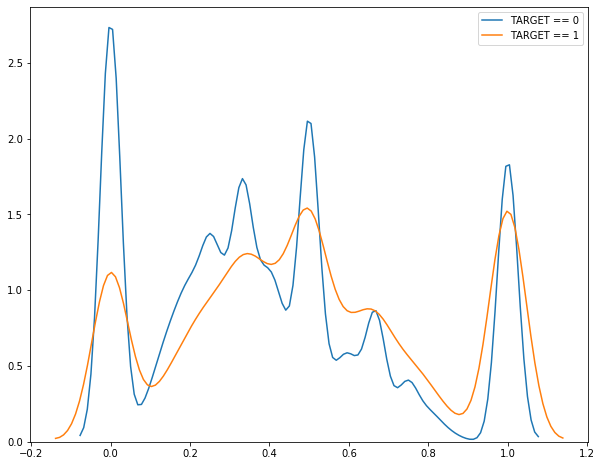

In [81]:
plt.figure(figsize=(10,8))
sns.kdeplot(train[train["TARGET"]==0]["bureau_CREDIT_ACTIVE_Active_mean"], label = 'TARGET == 0')
sns.kdeplot(train[train["TARGET"]==1]["bureau_CREDIT_ACTIVE_Active_mean"], label = 'TARGET == 1')


The figure shows very weak correlation, and I dont think we can draw a conclusion here.

#### 3.2.a Collinear variable

We also calculate the correlation between the features and remove the one of the each pairs which are highly correlated with eachothers

In [82]:
corrs.index[corrs['AMT_CREDIT']>0.85]

Index(['AMT_CREDIT', 'AMT_GOODS_PRICE'], dtype='object')

In [83]:
# Set the threshold
threshold = 0.85

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [84]:
len(above_threshold_vars)

158

In [85]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  49


We remove these columns from the 'train' dataset.

In [86]:
train_corrs_removed = train.drop(columns = cols_to_remove)


First, we split the data into train and test and then do the under-sampling and over-sampling.

In [87]:
X = train_corrs_removed.drop(['TARGET'], axis=1)
Y = train_corrs_removed['TARGET']

In [88]:
# one-hot encoding of categorical variables

X = pd.get_dummies(X)
X.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,-1186.0,-291,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#Spliting the train and test data

x_train,x_test, y_train,y_test = train_test_split(X,Y, random_state = 20, test_size=0.2)

In [90]:
df_train = pd.concat((x_train, y_train), axis=1)

### Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

In [91]:
#class count
count_class_0, count_class_1 = df_train['TARGET'].value_counts()

In [92]:
print(count_class_0)
print(count_class_1)

226147
19861


In [93]:
#Divide by class
df_class_0 = df_train[df_train['TARGET'] == 0]
df_class_1 = df_train[df_train['TARGET'] == 1]

#### Random under_sampling


In [94]:
df_class_0_under = df_class_0.sample(count_class_1)

In [95]:
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [96]:
print('Random under_sampling:')
print(df_under['TARGET'].value_counts())

Random under_sampling:
1    19861
0    19861
Name: TARGET, dtype: int64


## 4. Modeling

now, we continue with balanced data set. First we start with under_sampling data set 

In [100]:
y = df_under['TARGET']
x = df_under.drop(['TARGET'], axis =1 )


In [101]:
x = x.set_index(['SK_ID_CURR'])
x_test = x_test.set_index(['SK_ID_CURR'])

we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). 

In [102]:
# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(x)

# Transform both training and testing data
x = imputer.transform(x)
x_test = imputer.transform(x_test)

# Repeat with the scaler
scaler.fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

print('Training data shape: ', x.shape)
print('Testing data shape: ', x_test.shape)

C:\Users\Nastaran\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (39722, 247)
Testing data shape:  (61503, 247)


### 4.1 Logestic Regression

In [103]:
lr = LogisticRegression(penalty='l1')
lr.fit(x, y)

C:\Users\Nastaran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
lr_y_pred = lr.predict(x_test)
lr_y_prob = lr.predict_proba(x_test)[:,1]

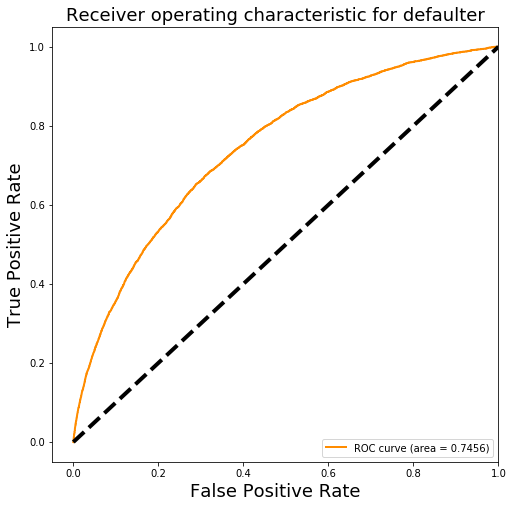

In [105]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for defaulter', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [106]:
confusion_matrix(y_test, lr_y_pred)

array([[38982, 17557],
       [ 1620,  3344]], dtype=int64)

In [107]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [108]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.6882 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.1600 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6737 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


### 4.2 Random Forest

In [109]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1)

In [110]:
random_forest.fit(x,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [111]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.drop(['SK_ID_CURR'], axis=1), 'importance': feature_importance_values})
feature_importances

,feature,importance
0,"(C, N, T, _, C, H, I, L, D, R, E, N)",0.005971
1,"(A, M, T, _, I, N, C, O, M, E, _, T, O, T, A, L)",0.019097
2,"(A, M, T, _, C, R, E, D, I, T)",0.025188
3,"(A, M, T, _, A, N, N, U, I, T, Y)",0.024581
4,"(R, E, G, I, O, N, _, P, O, P, U, L, A, T, I, ...",0.021255
...,...,...
242,"(W, A, L, L, S, M, A, T, E, R, I, A, L, _, M, ...",0.002312
243,"(W, A, L, L, S, M, A, T, E, R, I, A, L, _, M, ...",0.002435
244,"(W, A, L, L, S, M, A, T, E, R, I, A, L, _, M, ...",0.000596
245,"(E, M, E, R, G, E, N, C, Y, S, T, A, T, E, _, ...",0.002656


In [112]:
rf_y_pred = random_forest.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


In [113]:
rf_y_prob = random_forest.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished


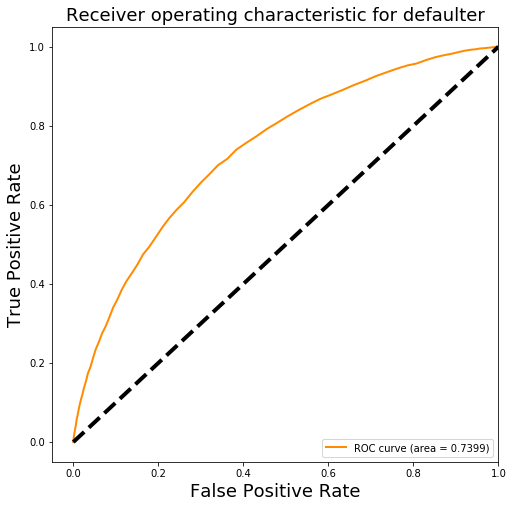

In [114]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for defaulter', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [115]:
summary_report(y_test, rf_y_pred)

Accuracy : 0.6970 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.1612 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6553 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


### 4.2.a Random Forest: different hyperparameter


In [116]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', max_depth=10 ,random_state = 50, verbose = 1)

In [117]:
rf.fit(x,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [118]:
rf_y_pred = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.0s finished


In [119]:
rf_y_prob = rf.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.1s finished


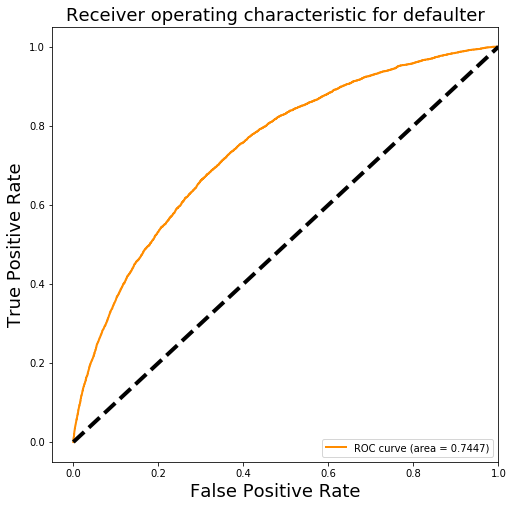

In [120]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for defaulter', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [121]:
summary_report(y_test, rf_y_pred)

Accuracy : 0.6826 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.1582 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6785 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [122]:
#importance feature
feature_importance_values = rf.feature_importances_

In [123]:
feature_importances = pd.DataFrame({'feature': list(X.drop(['SK_ID_CURR'], axis=1).columns), 'importance': feature_importance_values})


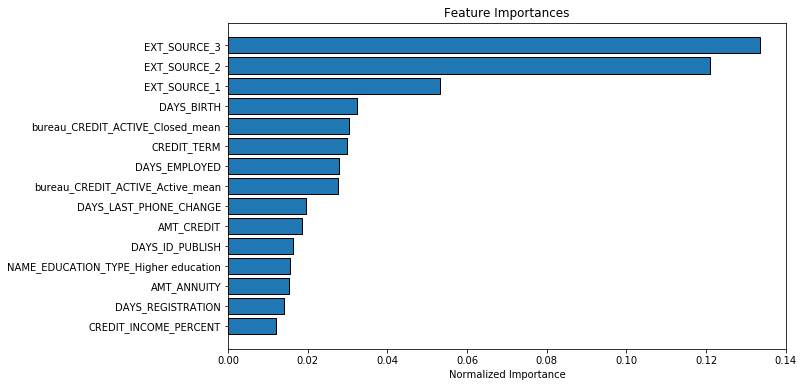

In [124]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

### 4.3 XGBoost

In [152]:
xgb = XGBClassifier(binary='logistic', random_state=50, max_depth=10, reg_alpha=10 )

In [153]:
xgb.fit(x,y)

XGBClassifier(base_score=0.5, binary='logistic', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [154]:
xgb_y_pred = xgb.predict(x_test)

In [155]:
xgb_y_prob = xgb.predict_proba(x_test)[:, 1]


In [161]:
xgb_y_prob

array([0.29482993, 0.26496467, 0.62690777, ..., 0.31257552, 0.22025117,
       0.29885995], dtype=float32)

(array([ 3956., 10585., 10586.,  8764.,  7205.,  6122.,  5210.,  4597.,
         3358.,  1120.]),
 array([0.03332114, 0.12596215, 0.21860316, 0.3112442 , 0.4038852 ,
        0.4965262 , 0.58916724, 0.68180823, 0.7744492 , 0.8670903 ,
        0.9597313 ], dtype=float32),
 <a list of 10 Patch objects>)

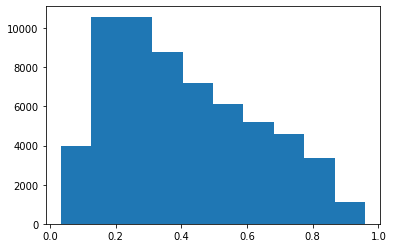

In [165]:
plt.hist(xgb_y_prob)

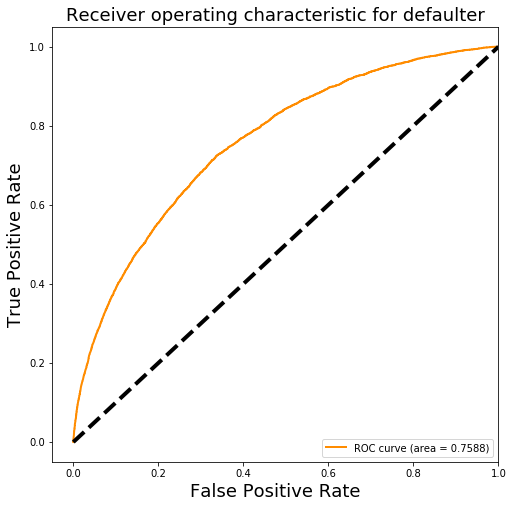

In [156]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for defaulter', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [157]:
summary_report(y_test, xgb_y_pred)

Accuracy : 0.7006 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.1668 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6783 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [158]:
feature_importance_values_xgb = xgb.feature_importances_

In [159]:
feature_importances_xgb = pd.DataFrame({'feature': list(X.drop(['SK_ID_CURR'], axis=1).columns), 'importance': feature_importance_values_xgb})


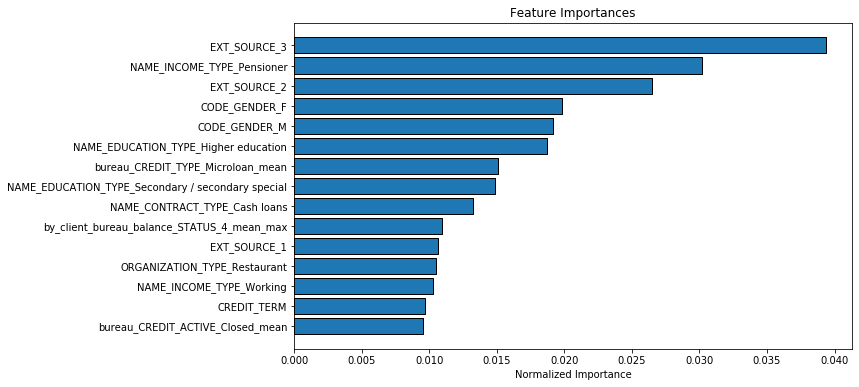

In [160]:
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances_xgb['importance_normalized'] = feature_importances_xgb['importance'] / feature_importances_xgb['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_xgb.index[:15]))), 
feature_importances_xgb['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_xgb.index[:15]))))
ax.set_yticklabels(feature_importances_xgb['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

## Calculating the potential average saving

In [251]:
(app_train[app_train['TARGET']==1]['AMT_CREDIT']).sum()

13846851949.5

In [254]:
(app_train[app_train['TARGET']==1]['AMT_CREDIT']).mean()

557778.527673716

In [255]:
app_train.groupby('TARGET')['AMT_CREDIT'].mean()

TARGET
0    602648.282002
1    557778.527674
Name: AMT_CREDIT, dtype: float64

In [256]:
app_train['TARGET'].sum()

24825

In [257]:
app_train['AMT_CREDIT'].sum()

184207084195.5

Recall (true positive rate) of the last model is 0.6783. This means that the model on average can correctly detect ~ 68% of all defaulters. The total number of defaulters in the whole data is 24825 and the average amount of credits granted to those clients is $557,778 per person.  

 Assuming that each defaulter would utilize the whole amount of available credit upon defaulting and also assuming that bank would not grant any credit to any client tagged by model as potential defaulter, bank would benefit from saving attributed to application of the model. This saving would equal to 24825 x 0.68 x $557,778 =  $9,277,390,678 = $9.3 bn.



It is important to note that this saving would materialize in the period of time starting on first loan origination date and ending on last load origination date in which we assume model has been used.


